In [5]:
# make_second_reward_dataset.py
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import joblib

CSV_FOLDERS = [
    Path(r"C:/Users/Developer/TCLab/csv/data_back3"),
    Path(r"C:/Users/Developer/TCLab/csv/data_back4"),
    Path(r"C:/Users/Developer/TCLab/csv/data_back5"),
    Path(r"C:/Users/Developer/TCLab/csv/data_back6"),
]
DT          = 5.0          # sample interval [s]
N_STEP      = 5           #   <-- ✨ n-step future reward
SAVE_NPZ    = Path(r"C:/Users/Developer/TCLab/Data/future_10step.npz")
SAVE_SCALER = Path(r"C:/Users/Developer/TCLab/Data/future_10step.pkl")

obs_buf, act_buf, next_buf, rew_buf, done_buf = [], [], [], [], []

for folder in CSV_FOLDERS:
    for csv_path in sorted(folder.glob("mpc_episode_*_data.csv")):
        df = pd.read_csv(csv_path).reset_index(drop=True)

        episode_len = len(df)
        for i in range(episode_len):
            
            j = i + N_STEP          # future index
            print(f"j : {j}, i : {i}")
            # 2-A. (s_t, a_t)
            s_t =  [df.at[i, "T1"],   df.at[i, "T2"],
                    df.at[i, "TSP1"], df.at[i, "TSP2"]]
            a_t =  [df.at[i, "Q1"],   df.at[i, "Q2"]]

            # 2-B. s_{t+1}  (즉시 다음 상태 – IQL 등은 1-step next 가 필요)
            if i < episode_len - 1:
                s_tp1 = [df.at[i+1, "T1"],   df.at[i+1, "T2"],
                         df.at[i+1, "TSP1"], df.at[i+1, "TSP2"]]
            else:                      # 마지막 샘플이면 자기 자신
                s_tp1 = s_t

            # 2-C. n-step future reward
            if j < episode_len:
                T_future1, T_future2 = df.at[j, "T1"], df.at[j, "T2"]
                TSP_now1, TSP_now2   = df.at[i, "TSP1"], df.at[i, "TSP2"]
            else: 
                continue

            err1 = TSP_now1 - T_future1
            err2 = TSP_now2 - T_future2
            r_t  = -np.sqrt(err1**2 + err2**2)
            done = (i == episode_len - 1)

            # 2-D. 버퍼에 push
            obs_buf.append(s_t)
            act_buf.append(a_t)
            next_buf.append(s_tp1)
            rew_buf.append(r_t)
            done_buf.append(done)

rew_arr   = np.array(rew_buf, dtype=np.float32).reshape(-1,1)
scaler    = StandardScaler().fit(rew_arr)
rew_norm  = scaler.transform(rew_arr).flatten()

dataset = {
    "observations"     : np.array(obs_buf,  dtype=np.float32),
    "actions"          : np.array(act_buf,  dtype=np.float32),
    "next_observations": np.array(next_buf, dtype=np.float32),
    "rewards"          : rew_norm.astype(np.float32),
    "terminals"        : np.array(done_buf, dtype=bool),
}
# SAVE_NPZ.parent.mkdir(parents=True, exist_ok=True)
# np.savez(SAVE_NPZ, **dataset)
# joblib.dump(scaler, SAVE_SCALER)

print(f"\n✅  NPZ saved  → {SAVE_NPZ}")
print(f"✅  Scaler saved → {SAVE_SCALER}")
print(f"Total transitions : {len(obs_buf):,}")
print(f"Reward mean/std   : {rew_norm.mean():.3f} / {rew_norm.std():.3f}")
print(f"Obs dim           : {dataset['observations'].shape[1]}")


j : 5, i : 0
j : 6, i : 1
j : 7, i : 2
j : 8, i : 3
j : 9, i : 4
j : 10, i : 5
j : 11, i : 6
j : 12, i : 7
j : 13, i : 8
j : 14, i : 9
j : 15, i : 10
j : 16, i : 11
j : 17, i : 12
j : 18, i : 13
j : 19, i : 14
j : 20, i : 15
j : 21, i : 16
j : 22, i : 17
j : 23, i : 18
j : 24, i : 19
j : 25, i : 20
j : 26, i : 21
j : 27, i : 22
j : 28, i : 23
j : 29, i : 24
j : 30, i : 25
j : 31, i : 26
j : 32, i : 27
j : 33, i : 28
j : 34, i : 29
j : 35, i : 30
j : 36, i : 31
j : 37, i : 32
j : 38, i : 33
j : 39, i : 34
j : 40, i : 35
j : 41, i : 36
j : 42, i : 37
j : 43, i : 38
j : 44, i : 39
j : 45, i : 40
j : 46, i : 41
j : 47, i : 42
j : 48, i : 43
j : 49, i : 44
j : 50, i : 45
j : 51, i : 46
j : 52, i : 47
j : 53, i : 48
j : 54, i : 49
j : 55, i : 50
j : 56, i : 51
j : 57, i : 52
j : 58, i : 53
j : 59, i : 54
j : 60, i : 55
j : 61, i : 56
j : 62, i : 57
j : 63, i : 58
j : 64, i : 59
j : 65, i : 60
j : 66, i : 61
j : 67, i : 62
j : 68, i : 63
j : 69, i : 64
j : 70, i : 65
j : 71, i : 66
j : 72, i 

✅ dt=1 보간 기반 Total Return: -6802.230


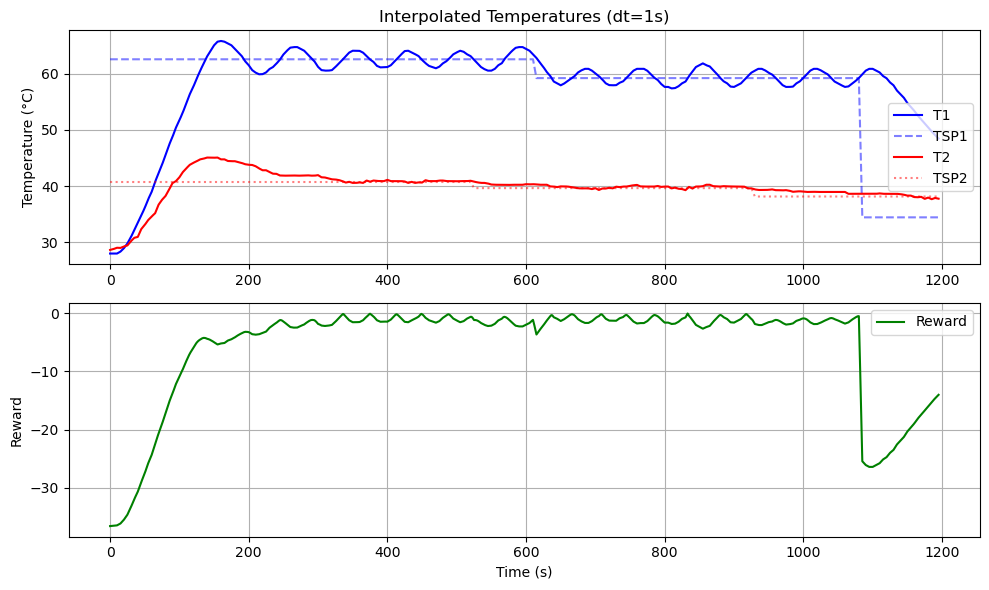

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 🔁 데이터 로드
csv_path = "C:/Users/Developer/TCLab/csv/data_back3/mpc_episode_2_data.csv"
df = pd.read_csv(csv_path)

# 🔧 원래 시간 벡터 (dt=5 기준)
t_5 = np.arange(len(df)) * 5  # 0, 5, 10, ...
t_1 = np.arange(t_5[0], t_5[-1] + 1, 1)  # 0, 1, 2, ..., T

# 📈 선형 보간 함수 정의
interp = lambda col: interp1d(t_5, df[col].values, kind='linear')(t_1)

T1_1s   = interp("T1")
T2_1s   = interp("T2")
TSP1_1s = interp("TSP1")
TSP2_1s = interp("TSP2")

# 🎯 Reward 계산 (dt=1 기준)
rewards_1s = -np.sqrt((TSP1_1s - T1_1s)**2 + (TSP2_1s - T2_1s)**2)
total_return = np.sum(rewards_1s)

print(f"✅ dt=1 보간 기반 Total Return: {total_return:.3f}")

# 📊 그래프 시각화
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t_1, T1_1s, label="T1", color="blue")
plt.plot(t_1, TSP1_1s, "--", label="TSP1", color="blue", alpha=0.5)
plt.plot(t_1, T2_1s, label="T2", color="red")
plt.plot(t_1, TSP2_1s, ":", label="TSP2", color="red", alpha=0.5)
plt.title("Interpolated Temperatures (dt=1s)")
plt.ylabel("Temperature (°C)")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_1, rewards_1s, label="Reward", color="green")
plt.xlabel("Time (s)")
plt.ylabel("Reward")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


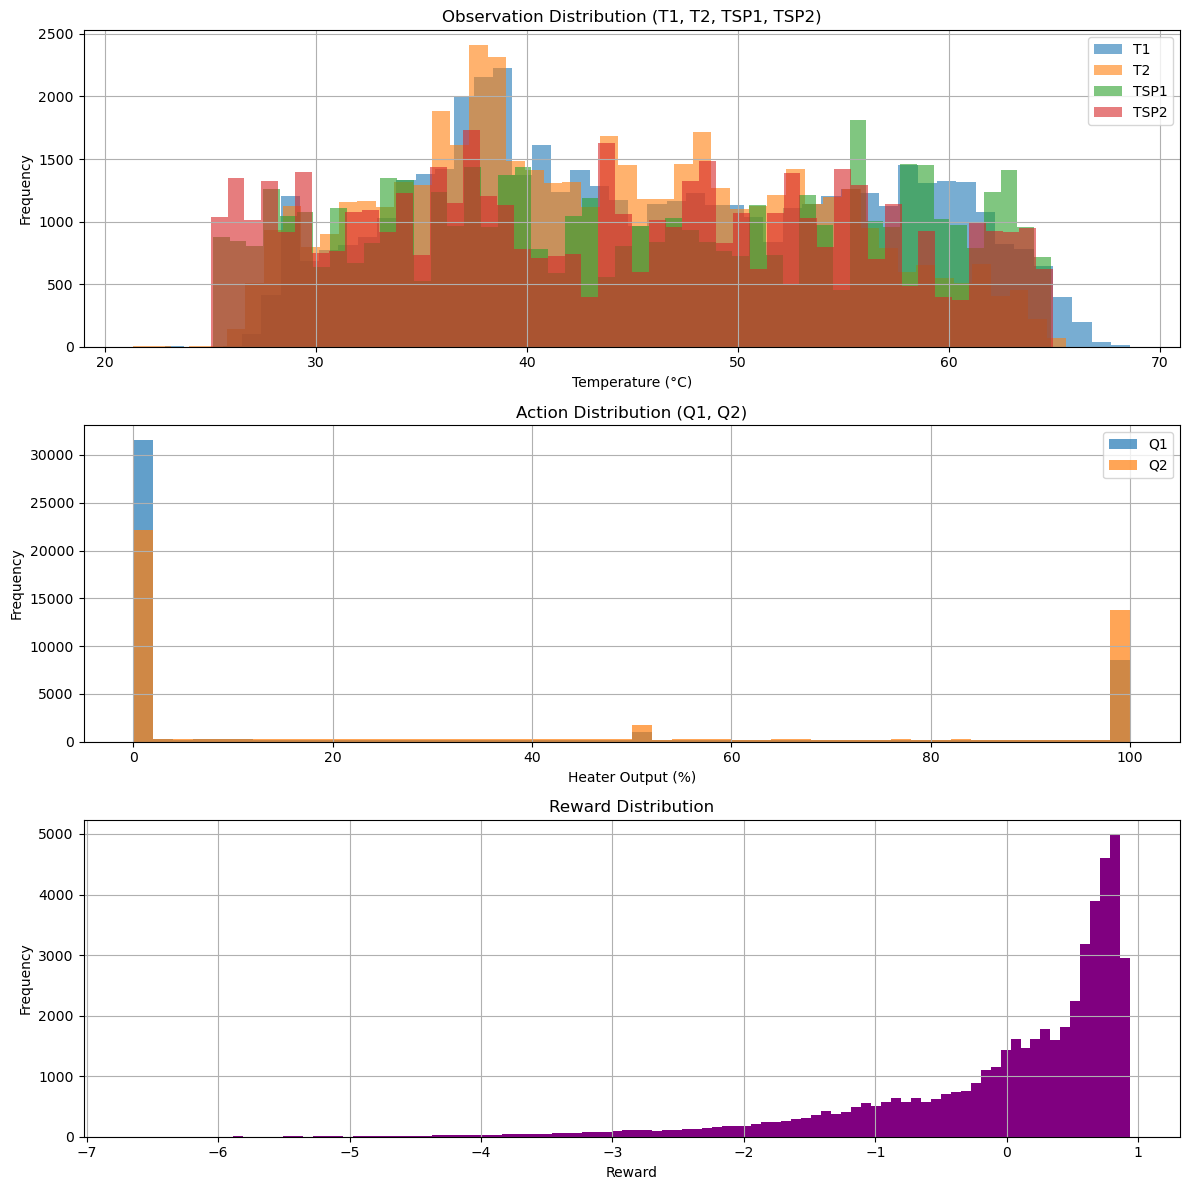

Reward mean: -1.2309694e-09
Reward std: 1.0


In [22]:
# Re-import after kernel reset
import numpy as np
import matplotlib.pyplot as plt

# Reload dataset
data = np.load("C:/Users/Developer/TCLab/Data/future_10step.npz")
# C:\\Users\\Developer\\TCLab\\Data\\mpc_dataset.npz
# Extract components
observations = data["observations"]
actions = data["actions"]
rewards = data["rewards"]

# Plot settings
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# 1. Observations (T1, T2, TSP1, TSP2)
axs[0].hist(observations[:, 0], bins=50, alpha=0.6, label="T1")
axs[0].hist(observations[:, 1], bins=50, alpha=0.6, label="T2")
axs[0].hist(observations[:, 2], bins=50, alpha=0.6, label="TSP1")
axs[0].hist(observations[:, 3], bins=50, alpha=0.6, label="TSP2")
axs[0].set_title("Observation Distribution (T1, T2, TSP1, TSP2)")
axs[0].set_xlabel("Temperature (°C)")
axs[0].set_ylabel("Frequency")
axs[0].legend()
axs[0].grid(True)

# 2. Actions (Q1, Q2)
axs[1].hist(actions[:, 0], bins=50, alpha=0.7, label="Q1")
axs[1].hist(actions[:, 1], bins=50, alpha=0.7, label="Q2")
axs[1].set_title("Action Distribution (Q1, Q2)")
axs[1].set_xlabel("Heater Output (%)")
axs[1].set_ylabel("Frequency")
axs[1].legend()
axs[1].grid(True)

# 3. Reward distribution
axs[2].hist(rewards, bins=100, color='purple')
axs[2].set_title("Reward Distribution")
axs[2].set_xlabel("Reward")
axs[2].set_ylabel("Frequency")
axs[2].grid(True)

plt.tight_layout()
plt.show()
print("Reward mean:", np.mean(rewards))
print("Reward std:", np.std(rewards))


In [28]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt

# 🎯 원래 리워드 분포
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(rew_arr, bins=100, color='skyblue', alpha=0.8)
plt.title("Raw Reward Distribution (before scaling)")
plt.xlabel("reward (raw)"); plt.ylabel("count")

# ✅ 스케일된 리워드 분포
plt.subplot(1, 2, 2)
plt.hist(rew_norm, bins=100, color='orange', alpha=0.8)
plt.title("Normalized Reward Distribution (after StandardScaler)")
plt.xlabel("reward (scaled)"); plt.ylabel("count")

plt.tight_layout()
plt.show()


               count  mean_abs   std_abs  50%_quantile  75%_quantile  \
abs(TSP - T)  101336  4.294495  6.214755      1.540001          5.26   

              90%_quantile  95%_quantile  
abs(TSP - T)     12.709999     18.579999  


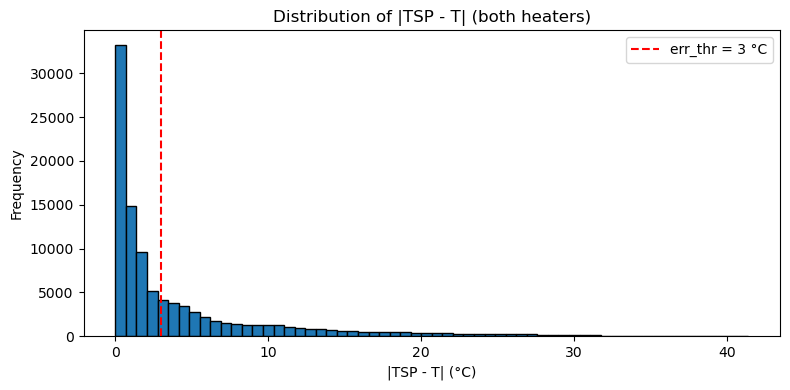

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ▼ 확인할 .npz 경로
npz_path = Path("C:/Users/Developer/TCLab/Data/MPC/future.npz")
data = np.load(npz_path)

# observations = [T1, T2, TSP1, TSP2]
obs = data["observations"]
delta1 = obs[:, 2] - obs[:, 0]     # TSP1 - T1
delta2 = obs[:, 3] - obs[:, 1]     # TSP2 - T2
abs_delta = np.abs(np.concatenate([delta1, delta2]))

# 통계량 계산
stats = {
    "count":        len(abs_delta),
    "mean_abs":     abs_delta.mean(),
    "std_abs":      abs_delta.std(),
    "50%_quantile": np.percentile(abs_delta, 50),
    "75%_quantile": np.percentile(abs_delta, 75),
    "90%_quantile": np.percentile(abs_delta, 90),
    "95%_quantile": np.percentile(abs_delta, 95),
}

df_stats = pd.DataFrame(stats, index=["abs(TSP - T)"])
print(df_stats)                    # ← 테이블 출력
# df_stats.to_csv("delta_stats.csv")   # 필요하면 파일로 저장

# 히스토그램 시각화
plt.figure(figsize=(8, 4))
plt.hist(abs_delta, bins=60, edgecolor="black")
plt.axvline(3, color="red", linestyle="--", label="err_thr = 3 °C")
plt.title("Distribution of |TSP - T| (both heaters)")
plt.xlabel("|TSP - T| (°C)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


📈 [Raw Reward Stats]
  Mean : -6.081
  Std  : 6.664
  Min  : -48.508
  Max  : -0.010

📈 [Scaled Reward Stats]
  Mean : -0.000
  Std  : 1.000
  Min  : -6.366
  Max  : 0.911


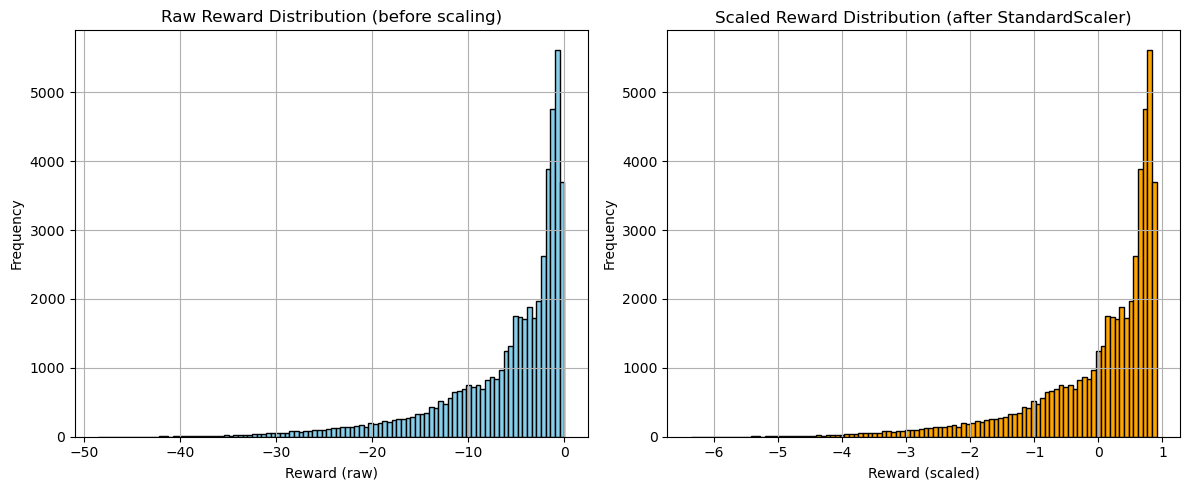

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# 🔍 CSV 경로들
CSV_FOLDERS = [
    Path(r"C:/Users/Developer/TCLab/csv/data_back3"),
    Path(r"C:/Users/Developer/TCLab/csv/data_back4"),
    Path(r"C:/Users/Developer/TCLab/csv/data_back5"),
    Path(r"C:/Users/Developer/TCLab/csv/data_back6"),
]

N_STEP = 5  # n-step reward 기준

# 🔁 보상 버퍼
reward_raw = []

for folder in CSV_FOLDERS:
    for csv_path in sorted(folder.glob("mpc_episode_*_data.csv")):
        df = pd.read_csv(csv_path).reset_index(drop=True)
        for i in range(len(df) - N_STEP):
            j = i + N_STEP

            TSP1, TSP2 = df.at[i, "TSP1"], df.at[i, "TSP2"]
            T1_n, T2_n = df.at[j, "T1"], df.at[j, "T2"]

            err1 = TSP1 - T1_n
            err2 = TSP2 - T2_n
            r_t = -np.sqrt(err1**2 + err2**2)  # 🔸 보상 계산

            reward_raw.append(r_t)

# 📦 Numpy 변환
reward_raw = np.array(reward_raw, dtype=np.float32).reshape(-1, 1)

# 🎯 스케일러 적용
scaler = StandardScaler().fit(reward_raw)
reward_scaled = scaler.transform(reward_raw).flatten()

# 📊 통계 출력
print("📈 [Raw Reward Stats]")
print(f"  Mean : {reward_raw.mean():.3f}")
print(f"  Std  : {reward_raw.std():.3f}")
print(f"  Min  : {reward_raw.min():.3f}")
print(f"  Max  : {reward_raw.max():.3f}")

print("\n📈 [Scaled Reward Stats]")
print(f"  Mean : {reward_scaled.mean():.3f}")
print(f"  Std  : {reward_scaled.std():.3f}")
print(f"  Min  : {reward_scaled.min():.3f}")
print(f"  Max  : {reward_scaled.max():.3f}")

# 📊 히스토그램 시각화
plt.figure(figsize=(12, 5))

# 원본 리워드
plt.subplot(1, 2, 1)
plt.hist(reward_raw.flatten(), bins=100, color='skyblue', edgecolor='black')
plt.title("Raw Reward Distribution (before scaling)")
plt.xlabel("Reward (raw)")
plt.ylabel("Frequency")
plt.grid(True)

# 정규화 리워드
plt.subplot(1, 2, 2)
plt.hist(reward_scaled, bins=100, color='orange', edgecolor='black')
plt.title("Scaled Reward Distribution (after StandardScaler)")
plt.xlabel("Reward (scaled)")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()


전체 샘플 수: 101336
▶|TSP1 - T1| > 1.5 인 개수: 27369
▶|TSP2 - T2| > 1.5 인 개수: 23819
총 오차(>1.0도) 개수: 51188
전체 중 1.5 이상 오차 비율: 50.51%


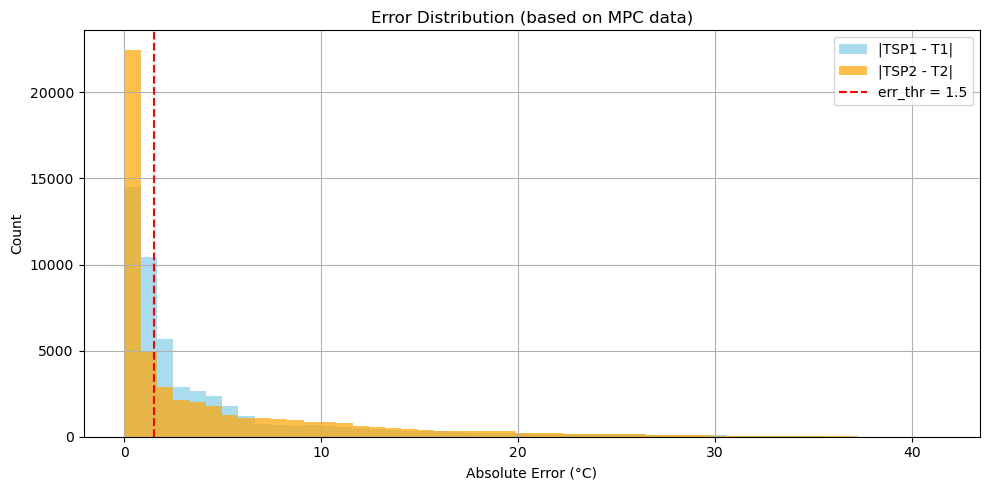

In [26]:
# 기존 코드 (생략 없이 유지)
import numpy as np
import matplotlib.pyplot as plt

data = np.load("C:/Users/Developer/TCLab/Data/MPC/future.npz")
obs = data["observations"]  # shape: (N, 4)

T1   = obs[:, 0]
T2   = obs[:, 1]
TSP1 = obs[:, 2]
TSP2 = obs[:, 3]

# 절대 오차 계산
err1 = np.abs(TSP1 - T1)
err2 = np.abs(TSP2 - T2)

# 🎯 오차 임계값 설정
err_thr = 1.5

# 전체 개수
total_samples = len(err1) + len(err2)

# ✅ 1도 이상 오차 개수 세기
cnt_err1 = np.sum(err1 > err_thr)
cnt_err2 = np.sum(err2 > err_thr)
total_cnt = cnt_err1 + cnt_err2

# ✅ 비율 계산
percent = total_cnt / total_samples * 100

# 출력
print(f"전체 샘플 수: {total_samples}")
print(f"▶|TSP1 - T1| > {err_thr} 인 개수: {cnt_err1}")
print(f"▶|TSP2 - T2| > {err_thr} 인 개수: {cnt_err2}")
print(f"총 오차(>1.0도) 개수: {total_cnt}")
print(f"전체 중 {err_thr} 이상 오차 비율: {percent:.2f}%")

# 📊 히스토그램 시각화
plt.figure(figsize=(10, 5))
plt.hist(err1, bins=50, alpha=0.7, label="|TSP1 - T1|", color='skyblue')
plt.hist(err2, bins=50, alpha=0.7, label="|TSP2 - T2|", color='orange')
plt.axvline(err_thr, color='red', linestyle='--', label=f"err_thr = {err_thr}")

plt.title("Error Distribution (based on MPC data)")
plt.xlabel("Absolute Error (°C)")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
